In [4]:
import numpy as np
from utils import COLORS, load_image
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [5]:
class GMM:
    def __init__(self, n_clusters, init_mus, init_covs, init_priors):
        self.n_clusters = n_clusters
        self.mus = np.array(init_mus)
        self.covs = np.array(init_covs)
        self.priors = np.array(init_priors)

    def inference(self, data):
        unnormalized_probs = []
        for i in range(self.n_clusters):
            mu = self.mus[i, :]
            cov = self.covs[i, :, :]
            prior = self.priors[i]
            unnormalized_prob = prior * \
                multivariate_normal.pdf(data, mean=mu, cov=cov)
            unnormalized_probs.append(np.expand_dims(unnormalized_prob, -1))
        pred = np.concatenate(unnormalized_probs, axis=1)
        log_likelihood = np.sum(np.log(np.sum(pred, axis=1)))
        pred = pred / np.sum(pred, axis=1, keepdims=True)
        return np.array(pred), log_likelihood

    def update(self, data, beliefs):
        soft_counts = np.sum(beliefs, axis=0)
        new_mus = []
        new_covs = []
        new_priors = []
        for i in range(self.n_clusters):
            new_mu = np.sum(np.expand_dims(beliefs[:, i], -1) * data, axis=0)
            new_mu /= soft_counts[i]
            new_mus.append(new_mu)
            data_shifted = np.subtract(data, np.expand_dims(new_mu, 0))
            new_cov = np.matmul(np.transpose(np.multiply(
                np.expand_dims(beliefs[:, i], -1), data_shifted)), data_shifted)
            new_cov /= soft_counts[i]
            new_covs.append(new_cov)
            new_priors.append(soft_counts[i]/np.sum(soft_counts))
        self.mus = np.array(new_mus)
        self.covs = np.array(new_covs)
        self.priors = np.array(new_priors)

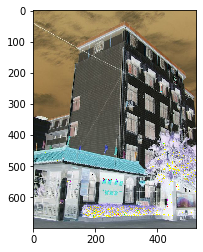

In [7]:
# load image
image_path = "./test.JPG"
image = load_image(image_path)
plt.imshow(np.round(image * 255).astype('uint8'), cmap='gray')
plt.show()

Iteration 1: Log Likelihood = -313392.8448151905
Iteration 2: Log Likelihood = -240205.68891951477
Iteration 3: Log Likelihood = -173685.21624341182
Iteration 4: Log Likelihood = -87765.7352979957
Iteration 5: Log Likelihood = -54797.54249161862
Iteration 6: Log Likelihood = -43393.649709761914
Iteration 7: Log Likelihood = -38666.10434258248
Iteration 8: Log Likelihood = -35522.62898299952
Iteration 9: Log Likelihood = -32918.16985338919
Iteration 10: Log Likelihood = -30657.32869521346
Iteration 11: Log Likelihood = -28724.464485118275
Iteration 12: Log Likelihood = -27130.854490672387
Iteration 13: Log Likelihood = -25860.729397685423
Iteration 14: Log Likelihood = -24862.88003877434
Iteration 15: Log Likelihood = -24069.876509923095
Iteration 16: Log Likelihood = -23417.062549187536
Iteration 17: Log Likelihood = -22850.77558494625
Iteration 18: Log Likelihood = -22328.67990310049
Iteration 19: Log Likelihood = -21816.70553726128
Iteration 20: Log Likelihood = -21284.998648830817
I

Iteration 165: Log Likelihood = 22554.803762288033
Iteration 166: Log Likelihood = 22554.803762289263
Iteration 167: Log Likelihood = 22554.803762290205
Iteration 168: Log Likelihood = 22554.80376229072
Iteration 169: Log Likelihood = 22554.80376229138
Iteration 170: Log Likelihood = 22554.803762291933
Iteration 171: Log Likelihood = 22554.80376229213
Iteration 172: Log Likelihood = 22554.803762292602
Iteration 173: Log Likelihood = 22554.8037622929
Iteration 174: Log Likelihood = 22554.80376229299


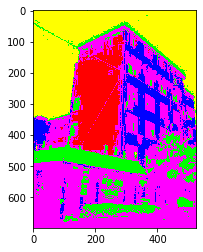

In [8]:
h, w, c = image.shape
pixels = np.reshape(image, (-1, c))
_mean = np.mean(pixels, axis=0, keepdims=True)
_std = np.std(pixels, axis=0, keepdims=True)
pixels = (pixels - _mean) / _std    # normalization

n_clusters = 5

kmeans = KMeans(n_clusters)
labels = kmeans.fit_predict(pixels)
init_mus = kmeans.cluster_centers_
init_priors, init_covs = [], []
for i in range(n_clusters):
    data = pixels[labels == i, :].T
    init_covs.append(np.cov(data))
    init_priors.append(data.shape[1] / len(labels))

gmm = GMM(n_clusters, init_mus, init_covs, init_priors)

# EM algorithm
prev_log_likelihood = None
for i in range(720):
    beliefs, log_likelihood = gmm.inference(pixels)
    gmm.update(pixels, beliefs)
    print("Iteration {}: Log Likelihood = {}".format(i+1, log_likelihood))
    if prev_log_likelihood != None and abs(log_likelihood - prev_log_likelihood) < 1e-10:
        break
    prev_log_likelihood = log_likelihood

beliefs, log_likelihood = gmm.inference(pixels)
map_beliefs = np.reshape(beliefs, (h, w, n_clusters))
segmented_map = np.zeros((h, w, 3))
for i in range(h):
    for j in range(w):
        hard_belief = np.argmax(map_beliefs[i, j, :])
        segmented_map[i, j, :] = np.array(COLORS[hard_belief]) / 255.0
plt.imshow(segmented_map)
plt.show()

# Report
The only parameter for GMM algorithm is the number of clusters for K means. Here I use 5 clusters and it shows a relatively good result. However, the building on the right cannot be classified clearly against the people and traffic marks far away.